## Funtional API

사용할 패키지를 불러옵니다.

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from utils import standard_scaling, R_squared, train_val_split
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

캘리포니아 집값 데이터 클래스를 불러옵니다.

In [2]:
housing = fetch_california_housing()

데이터를 훈련, 검증, 테스트 데이터로 나눕니다.

In [3]:
x_train_full, x_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full)

입력값들을 정규화 시켜줍니다.

In [4]:
x_train = standard_scaling(x_train)
x_val = standard_scaling(x_val)
x_test = standard_scaling(x_test)

2층 와이드 & 딥 신경망을 함수형 api로 구현하겠습니다.  
일부 특성은 짧은 경로로 간단한 규칙을 학습하고, 다른 특성을 깊은 경로로 복잡한 패턴을 학습하는 구조입니다.

In [5]:
input_a = Input(shape=[5], name="wide_input") # 5개의 특성은 바로 연결층으로
input_b = Input(shape=[6], name="deep_input") # 6개의 특성은 깊은 은닉층으로

hidden1 = Dense(30, activation="relu")(input_b) # 첫 번째 은닉층
hidden2 = Dense(30, activation="relu")(hidden1) # 두 번째 은닉층

concat = Concatenate()([input_a, hidden2]) # 첫 번째 입력층과 두 번째 은닉층 결합층
output = Dense(1)(concat) # 출력층

model = Model(inputs=[input_a, input_b], outputs=[output]) # 설계된 입, 출력층을 모델로 묶음

만들어진 함수형 모델의 구조를 확인합니다.

<img src="https://imgur.com/X3bDNJx.jpg" width="250">

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
______________________________________________________________________________________________

구조가 확정된 모델의 학습방법을 지정하고 학습을 진행합니다.  
추가적으로 모델의 과대적합을 피하기 위한 조기종료 콜백을 추가합니다.

In [7]:
input_train_5, input_train_6 = x_train[:,:5], x_train[:,2:]
input_val_5, input_val_6 = x_val[:,:5], x_val[:,2:]
input_test_5, input_test_6 = x_test[:,:5], x_test[:,2:]

model.compile(loss="mean_squared_error", # 손실함수로는 평균제곱오차를 사용
              optimizer="sgd" # 최적화기법으로 확률적 경사하강법 사용
             )  

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, # 3번까지 모델이 향상도지 않으면 조기종료
                                                  restore_best_weights=True # 훈련이 끝난 후 최상의 가중치 복원
                                                 )

history = model.fit((input_train_5, input_train_6),
                    y_train,
                    epochs=20, # 전체 데이터 학습 횟수
                    validation_data=((input_val_5, input_val_6), y_val), # 에폭마다 검증 데이터 결과 출력
                    callbacks=[early_stopping_cb] # 조기종료 콜백 사용
                   )
mse_test = model.evaluate((input_test_5, input_test_6), y_test) # 완성된 모델의 테스트 데이터 결과 출력

Epoch 1/20
363/363 [==============================] - 5s 9ms/step - loss: 1.3736 - val_loss: 0.5364
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5420 - val_loss: 0.6141
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5060 - val_loss: 0.4599
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4430 - val_loss: 0.4396
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4375 - val_loss: 0.4262
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3985 - val_loss: 0.4192
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3991 - val_loss: 0.4556
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3997 - val_loss: 0.4071
Epoch 9/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3914 - val_loss: 0.4227
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3781 - val_loss: 0.4047

모델이 학습 잘 학습되어지는지 에폭마다 손실함수 값을 확인합니다.

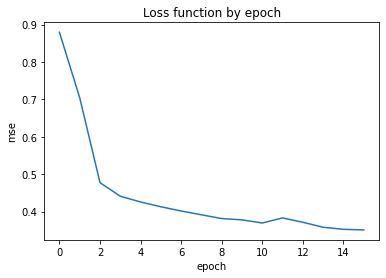

In [8]:
plt.plot(history.history["loss"])
plt.title("Loss function by epoch")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.show()

학습된 모델의 성능 검증을 위하여 결정계수를 구합니다.

In [9]:
pred_y = model.predict((input_test_5, input_test_6))
y_test = y_test.reshape(-1,1)
evaluate = R_squared(pred_y, y_test) # 결정계수
evaluate

0.6962914843572879

이번에는 출력층을 여러개로 한 모델을 만들겠습니다.  
출력층이 여러개 인 경우는 다중 분류 문제를 해결하거나 규제 기법으로 사용하는 경우 입니다.  
신경망 구조 안에서 보조 출력을 추가함으로써 하위 네트워크가 나머지 네트워크에 의존하지 않고 그자체로 유용한 것을 학습하는지 확인 할 수 있습니다.

In [22]:
input_a = Input(shape=[5], name="wide_input") # 5개의 특성은 바로 연결층으로
input_b = Input(shape=[6], name="deep_input") # 6개의 특성은 깊은 은닉층으로

hidden1 = Dense(30, activation="relu")(input_b) # 첫 번째 은닉층
hidden2 = Dense(30, activation="relu")(hidden1) # 두 번째 은닉층

concat = Concatenate()([input_a, hidden2]) # 첫 번째 입력층과 두 번째 은닉층 결합층
total_output = Dense(1, name="total_output")(concat) # 출력층
flat_output = Dense(1, name="flat_output")(input_a) # 출력층
aux_output = Dense(1, name="aux_output")(hidden2) # 보조 출력층

model = Model(inputs=[input_a, input_b], outputs=[total_output, flat_output, aux_output]) # 설계된 입, 출력층을 모델로 묶음

만들어진 함수형 모델의 구조를 확인합니다.

<img src="https://imgur.com/sonH2gM.jpg" width="300">

In [23]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 30)           930         dense_7[0][0]                    
____________________________________________________________________________________________

각 출력층은 자신만의 손실함수가 필요하므로 모델 컴파일시 따로 지정해야 합니다.  
기본적으로 케라스는 나열된 손실을 모두 더하여 최종손실을 구해 훈련에 사용합니다.  
보조 출력을 규제로만 사용한다면 주 출력의 손실에 더 많은 가중치를 부여할 수 있습니다.

In [24]:
model.compile(loss=["mse", "mse", "mse"], # [main_loss, flat_loss, aux_loss]
              loss_weights=[0.8, 0.1, 0.1], # main_ouput에 좀 더 가중치를 준 상태임
              optimizer="sgd" # 최적화 기법
             )

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, # 3번까지 모델이 향상도지 않으면 조기종료
                                                  restore_best_weights=True # 훈련이 끝난 후 최상의 가중치 복원
                                                 )

history = model.fit((input_train_5, input_train_6),
                    y_train,
                    epochs=20, # 전체 데이터 학습 횟수
                    validation_data=((input_val_5, input_val_6), y_val), # 에폭마다 검증 데이터 결과 출력
                    callbacks=[early_stopping_cb] # 조기종료 콜백 사용
                   )
loss, total_loss, flat_loss, aux_loss = model.evaluate((input_test_5, input_test_6), y_test) # 완성된 모델의 테스트 데이터 결과 출력

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 1.8797 - total_output_loss: 1.3942 - flat_output_loss: 5.0412 - aux_output_loss: 2.6017 - val_loss: 1.1113 - val_total_output_loss: 0.9690 - val_flat_output_loss: 2.1778 - val_aux_output_loss: 1.1831
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 1.0248 - total_output_loss: 0.8960 - flat_output_loss: 1.8701 - aux_output_loss: 1.2095 - val_loss: 0.6370 - val_total_output_loss: 0.5204 - val_flat_output_loss: 1.2230 - val_aux_output_loss: 0.9839
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5979 - total_output_loss: 0.4867 - flat_output_loss: 1.0813 - aux_output_loss: 1.0041 - val_loss: 0.5467 - val_total_output_loss: 0.4583 - val_flat_output_loss: 0.9898 - val_aux_output_loss: 0.8100
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5202 - total_output_loss: 0.4413 - flat_output_loss: 0.8565 - aux_output_loss: 0.8147 - val_loss: 0.51

모델이 학습 잘 학습되어지는지 에폭마다 모든 종류의 손실함수 값을 확인합니다.

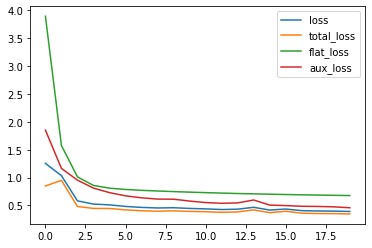

In [25]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["total_output_loss"], label="total_loss")
plt.plot(history.history["flat_output_loss"], label="flat_loss")
plt.plot(history.history["aux_output_loss"], label = "aux_loss")
plt.legend()

각 출력층에서의 결정계수를 구합니다.

In [26]:
total_pred_y, flat_pred_y, aux_pred_y = model.predict([input_test_5, input_test_6])
y_test = y_test.reshape(-1,1)
main_evaluate = R_squared(main_pred_y, y_test) # main 출력층의 결정계수
aux_evaluate = R_squared(aux_pred_y, y_test) # aux 출력층의 결정계수
flat_evaluate = R_squared(flat_pred_y, y_test) # flat 출력층의 결정계수
main_evaluate, flat_evaluate, aux_evaluate

(0.6876427069035236, 0.5065682306445015, 0.59752633964939)

은닉층만 거친 보조 출력층의 결정계수보다 입력층 A의 특성을 고려한 메인 출력층의 결정계수가 더 높은 것으로 보아 은닉층을 거쳐서 나온 복잡한 패턴은 모델의 성능에 크게 기여하지 못한 것으로 보입니다.  
또는 입력층 A에서의 단순한 패턴이 모델의 학습에 효과적이라고 볼 수 있습니다.  
보조 출력층의 손실함수 가중치 비율을 더 낮춰도 좋을 거 같습니다.